# Mercedes Benz Mobility - Interview Task

> Create a jupyter notebook to train a segmentation model for damage detection based on the given training data.
---
### Contents
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
   1. Loading Ground Truth
   2. Creating masks from polygons
   3. Resizing and padding
   4. Data Augmentation
3. Training the Classifier
   1. Creating a tensorflow dataset
   2. Building the model
   3. Training the model
   4. Evaluating the model
4. Conclusion

---

## 1. EDA

#### Imports

In [1]:
# suppress matplotlib inline warnings
import warnings
warnings.filterwarnings("ignore")

from typing import Tuple, List, Dict
import json
import logging
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
from functools import reduce
from PIL import Image, ImageOps
from matplotlib import cm
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Conv2DTranspose
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
import keras.backend as K

import shapely
import matplotlib.pyplot as plt
from matplotlib.path import Path
%matplotlib inline

#### Config

In [2]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s -  %(asctime)s: %(message)s')

# Setting up File Paths
RAW_DATA_PATH = '../data/raw'
PREPPED_DATA_PATH = '../data/prepped'

dirname = os.getcwd()
filename_val_bounding_boxes = os.path.join(dirname, RAW_DATA_PATH, 'val/via_region_data.json')
filename_train_bounding_boxes = os.path.join(dirname, RAW_DATA_PATH, 'train/via_region_data.json')

#### Loading Ground Truth

To get an idea of what the model is supposed to predict, I first load the ground truth that is stored as a json object.

In [58]:
with open(filename_train_bounding_boxes, 'r') as f:
  train_bounding_boxes = json.load(f)

Checking number of entries

In [59]:
len(train_bounding_boxes)

52

In [60]:
train_bounding_boxes

{'test_pattern_qbist.jpg129855': {'fileref': '',
  'size': 129855,
  'filename': 'test_pattern_qbist.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'a_swan_swimming_in_geneve_lake.jpg62201': {'fileref': '',
  'size': 62201,
  'filename': 'a_swan_swimming_in_geneve_lake.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'sinus_test_pattern.jpg27894': {'fileref': '',
  'size': 27894,
  'filename': 'sinus_test_pattern.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'image67.jpg47277': {'fileref': '',
  'size': 47277,
  'filename': 'image67.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298],
     'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]},
    'region_attributes': {'name': 'damage'}},
   '1': {'shape_attributes': {'name': 'polygon',
     'all_

Next, I turned the json dictionary into a pandas dataframe, which is easier to manipulate.

In [61]:
train_df = pd.DataFrame.from_dict(train_bounding_boxes)
train_df = train_df.transpose().reset_index()
# Remove first three rows as they contain images that are not actually in the dataset
train_df = train_df.iloc[3: , :].reset_index(drop=True)

In [62]:
train_df.head()

,index,fileref,size,filename,base64_img_data,file_attributes,regions
0,image67.jpg47277,,47277,image67.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg19024,,19024,image66.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg102144,,102144,image65.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg85335,,85335,image64.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg24447,,24447,image63.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."


Check data for duplicates.

In [63]:
sum(train_df.duplicated(subset=['index','filename']))

0

Calculate average image size.

In [64]:
train_df['size'].mean()

137704.306122449

Columns fileref, size, base64_img_data and file_attributes where identified to be either empty or not relevant to the given task and were therfore dropped to simplify the dataframe.

In [65]:
train_df = train_df.drop(['index', 'fileref', 'size', 'base64_img_data', 'file_attributes'], axis=1)

In [66]:
train_df.head()

,filename,regions
0,image67.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


Expand 'regions' dict to examine structure of the training data.

In [67]:
 train_df['regions'].apply(pd.Series).head()

,0,1,2,3,4
0,"{'shape_attributes': {'name': 'polygon', 'all_...","{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN
1,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
2,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
3,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
4,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN


The table above shows that one image can contain multiple regions of interest. The provided dataset appears to only contain shapes of type 'polygon'. They are also all of type 'damage'. The image segmentation model therefor only has to predict the region of the polygon.

In [68]:
 train_df['regions'].apply(pd.Series)['0'][23]

{'shape_attributes': {'name': 'polygon',
  'all_points_x': [226, 175, 160, 164, 174, 189, 197, 218, 236, 226],
  'all_points_y': [62, 139, 178, 202, 207, 181, 138, 117, 80, 62]},
 'region_attributes': {'name': 'damage'}}

Analyse the maximum number of points used for the polygon throughout the dataset.

In [69]:
resolution_of_polygons = []

for row in train_df['regions']:
    for region in row.values():
        resolution_of_polygons.append(len(region['shape_attributes']['all_points_x']))

print(f'Maximum number of polygons used: {max(resolution_of_polygons)}')
print(f'Average number of polygons used: {sum(resolution_of_polygons) / len(resolution_of_polygons)}')

Maximum number of polygons used: 33
Average number of polygons used: 13.602564102564102


It looks like the number of points for a polygon contained in the training data are not capped. 

#### Displaying Examples for Bounding Boxes from the Training Set

Helper-function to display the image and overlay the polygon of a given image.

In [70]:
def show_bounding_box(regions: dict, img_path: str)-> None:
    image = cv2.imread(img_path)
    isClosed = True
    color = (255,23,200)
    thickness = 3
        
    regions = list(regions)
    # remove nan from list
    regions = [x for x in regions if str(x) != 'nan']

    # draw polygon for all regions
    for region in regions:
        x = region['shape_attributes']['all_points_x']
        y = region['shape_attributes']['all_points_y']

        poly = np.array(list(zip(x, y)), np.int32)
            
        cv2.polylines(image, [poly], isClosed, color, thickness)
    
    plt.imshow(image)
    plt.show()

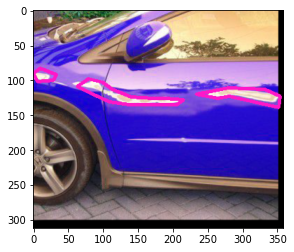

In [71]:
SAMPLE_INDEX = 43

show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

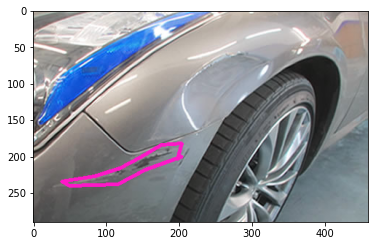

In [72]:
SAMPLE_INDEX = 5

show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

Further observations:
- Images are not uniform in size nor aspect ratio
- Images have varying resolutions and camera angles 
- number of available training images is very small

## 2. Data Preperation

#### Loading Ground Truth

In [73]:
def load_ground_truth(path: str, filename: str = 'via_region_data.json') -> pd.DataFrame:
    """Load ground truth from json and apply basic transformations

    Args:
        path (str): path to the directory that contains ground truth
        filename (str, optional): filename of ground truth file. Defaults to 'via_region_data.json'.

    Returns:
        pd.DataFrame: ground truth transformed into dataframe.
    """
    with open(os.path.join(path, filename), 'r') as f:
        ground_truth = json.load(f)
        ground_truth = pd.DataFrame.from_dict(ground_truth)

        ground_truth = ground_truth.transpose().reset_index()
        ground_truth = ground_truth.iloc[3: , :].reset_index(drop=True)

        ground_truth = ground_truth.drop(['index', 'fileref', 'size', 'base64_img_data', 'file_attributes'], axis=1)
    return ground_truth

#### Creating masks from Polygons

The common approach for image segmentation is to used masks that classify each pixel of a given image into a certain class. To obtain these masks, I used the polygon coordinates provided in the dataset.

In [74]:
def get_image_dimensions(img_path: str) -> Tuple[int, int]:
    """Get image dimensions from a given image.

    Args:
        img_path (str): path and filename of the image.

    Returns:
        Tuple[int, int]: image dimensions as a tupel.
    """
    img = cv2.imread(img_path)
    return img.shape[:2]

Turn polygons into image masks.

In [75]:
def get_mask_from_poly(dimensions: Tuple[int, int], regions: Dict[str, List]) -> np.ndarray:
    """create a mask from a polygon dictionary and return it as a numpy array.

    Args:
        dimensions (Tuple[int, int]): dimensions of the image
        regions (Dict[str, List]): coordinates of the polygon

    Returns:
        np.ndarray: mask of the polygon as numpy array
    """
    x, y = np.mgrid[:dimensions[0], :dimensions[1]]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    masks = []

    for region in regions.values():
        poly = list(zip(region['shape_attributes']['all_points_y'], region['shape_attributes']['all_points_x']))
        poly_path=Path(poly)

        masks.append(poly_path.contains_points(coors))
        
    full_mask = reduce(np.logical_or, masks)
    
    return full_mask.reshape(dimensions[0], dimensions[1])

Display the generated mask.

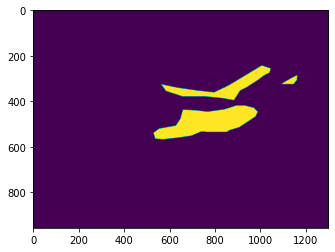

In [76]:
# TESTING
SAMPLE_INDEX = 24

reg = train_df.loc[SAMPLE_INDEX]['regions']
folder_path = os.path.join(dirname, RAW_DATA_PATH, 'train')
img_dim = get_image_dimensions(os.path.join(folder_path, train_df.loc[SAMPLE_INDEX]['filename']))

plt.imshow(get_mask_from_poly(img_dim, reg))
plt.show()

Comparision to the original polygon.

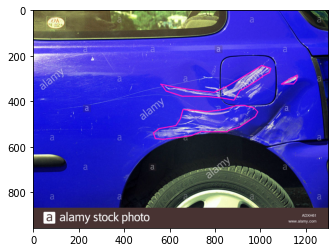

In [77]:
show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

In [78]:
def generate_masks(df: pd.DataFrame, read_path: str) -> Tuple[List[np.ndarray], List[int]]:
    """Generate masks for all images in a dataframe. 

    Args:
        df (pd.DataFrame): Must contain columns 'filename' and 'regions'
        read_path (str): path that contains the images referenced in 'filename'

    Returns:
        Tuple[List[np.ndarray], List[int]]: List of masks, list of dimensions
    """
    masks = []
    dimensions = []

    for index, row in df.iterrows():
        img_dim = get_image_dimensions(os.path.join(read_path, row['filename']))
        masks.append(get_mask_from_poly(img_dim, row['regions']))
        dimensions.append(img_dim)
    
    return masks, dimensions

#### Resize images and masks

Since the machine learning model needs the shape of the input to remain constant, the images (and corresponding masks) have to be resized.

In [67]:
def resize_image_and_mask(row: pd.Series, targetSize: int, readPath: str, writePath: str) -> Tuple[np.ndarray, np.ndarray]:
    """Resize an image and its mask to a target size and write it to a new location.

    Args:
        row (pd.Series): dataframe row, must contain 'filename' and 'mask'
        targetSize (int): target dimensions for the final image and mask
        readPath (str): where to read the image from
        writePath (str): where to write the resized image and mask to

    Returns:
        Tuple[np.ndarray, np.ndarray]: resized image and mask
    """
    # if resized image or mask dont exist yet
    if not (os.path.isfile(os.path.join(writePath, row['filename'])) and os.path.isfile(os.path.join(writePath, 'mask_' + row['filename']))):
        img = cv2.imread(os.path.join(readPath, row['filename']))
        mask = Image.fromarray(row['mask']).convert('L')
        mask = np.array(mask)

        f1 = targetSize / img.shape[1]
        f2 = targetSize / img.shape[0]
        f = min(f1, f2) 
        dim = (int(img.shape[1] * f), int(img.shape[0] * f))

        img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
        mask_resized = cv2.resize(mask, dim, interpolation = cv2.INTER_NEAREST)
        
        offset_y = int((targetSize - img_resized.shape[0]) / 2)
        offset_x = int((targetSize - img_resized.shape[1]) / 2)
        correct_offset_x = 0
        correct_offset_y = 0
        if offset_y*2 + img_resized.shape[0] < 256: correct_offset_y += 1
        if offset_x*2 + img_resized.shape[1] < 256: correct_offset_x += 1

        # Alternative padding method
        # padded_img = cv2.copyMakeBorder(img_resized, offset_y, offset_y+correct_offset_y, offset_x, offset_x+correct_offset_x, cv2.BORDER_CONSTANT, value = 0)
        # padded_mask = cv2.copyMakeBorder(mask_resized, offset_y, offset_y+correct_offset_y, offset_x, offset_x+correct_offset_x, cv2.BORDER_CONSTANT, value = 0)

        padded_img = cv2.copyMakeBorder(img_resized, offset_y, offset_y+correct_offset_y, offset_x, offset_x+correct_offset_x, cv2.BORDER_REFLECT)
        padded_mask = cv2.copyMakeBorder(mask_resized, offset_y, offset_y+correct_offset_y, offset_x, offset_x+correct_offset_x, cv2.BORDER_REFLECT)

        padded_img = Image.fromarray(padded_img)
        padded_img.save(os.path.join(writePath, 'images', row['filename']))
        # .png for lossless files
        padded_mask = Image.fromarray(padded_mask)
        padded_mask.save(os.path.join(writePath, 'masks', row['filename'] + ".png"), compress_level=0, optimize=False)
    else:
        logging.debug('Resized image and mask already exist.')
        padded_img = Image.open(os.path.join(writePath, 'images', row['filename']))
        padded_mask = Image.open(os.path.join(writePath, 'masks', row['filename'] + ".png"))
    
    return padded_img, padded_mask 

#### Data Augmentation

To improve the accurary of the classification and improve the model's ability to generalize to new images, data augmentation is used to increase the number of training samples.

In [94]:
# define sequence of augmentations to be used 
seq = iaa.Sequential([
    iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode="reflect"), #crop
    iaa.Fliplr(0.5), # flip
	iaa.Affine(rotate=(-25, 25), mode='reflect'), # rotate, translate
], random_order=True)


def augment_seg( img: np.ndarray, seg: np.ndarray ) -> Tuple[np.ndarray, np.ndarray]:
	"""Creates augmentations for a given image and its mask

	Args:
		img (np.ndarray): Base image
		seg (np.ndarray): Base mask

	Returns:
		Tupel[np.ndarray, np.ndarray]: _description_
	"""
	aug_det = seq.to_deterministic() 
	image_aug = aug_det.augment_image( img )

	seg = np.array(seg)
	
	# seg = PIL.Image.fromarray(seg)
	# thresh = 100
	# fn = lambda x : 255 if x > thresh else 0
	# seg = seg.convert('L').point(fn, mode='1')
	# seg = np.array(seg)

	segmap = ia.SegmentationMapOnImage( seg , nb_classes=np.max(seg)+1 , shape=img.shape )
	segmap_aug = aug_det.augment_segmentation_maps( segmap )
	segmap_aug = segmap_aug.get_arr_int()

	return image_aug , segmap_aug

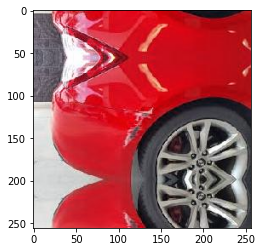

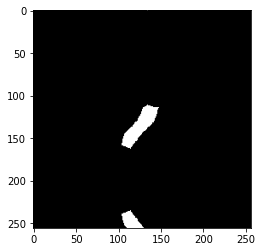

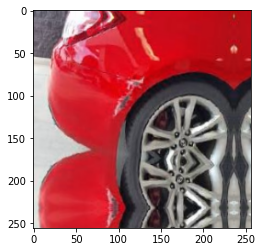

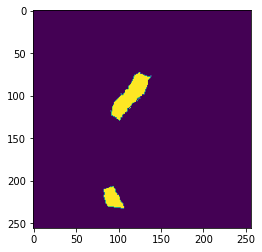

In [99]:
# Test augmentation
mask = cv2.imread(r"C:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\data\prepped\val\masks\image61.jpeg.png")
img = cv2.imread(r"C:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\data\prepped\val\images\image61.jpeg")

plt.imshow(img)
plt.show()

plt.imshow(mask)
plt.show()

mask = PIL.Image.fromarray(mask)
thresh = 100
fn = lambda x : 255 if x > thresh else 0
mask = mask.convert('L').point(fn, mode='1')
mask = np.array(mask)

image_aug , segmap_aug = augment_seg(img , mask)

plt.imshow(image_aug)
plt.show()

plt.imshow(segmap_aug)
plt.show()

In [83]:
def generate_augmentations(img, mask, row: pd.Series, path : str, no_augments: int  = 5):
    """Generate augmentations for a given image and its mask and save them.

    Args:
        img (_type_): Base Image
        mask (_type_): Mask as numpy array
        row (pd.Series): must contain 'filename' 
        path (str): where to save the augmented images
        no_augments (int, optional): number of different augmentations. Defaults to 5.
    """
    # convert from PIL to CV2
    img = np.array(img) 
    mask = np.array(mask) 
    
    augmentations = [augment_seg(img, mask) for _ in range(no_augments)]

    for index, aug in enumerate(augmentations):
        cv2.imwrite(os.path.join(path, 'images', row['filename'] + f'_aug_{index}.png'), aug[0]) # image
        cv2.imwrite(os.path.join(path, 'masks',  row['filename'] + f'_aug_{index}.png'), aug[1]) # mask

#### Data Prep Pipeline

In [84]:
def run_pipeline(target_size: int, no_augmentations: int, subdir: str) -> pd.DataFrame:
    """Prepare Data for training.

    Args:
        target_size (int): Target size for images and masks (longest edge)
        no_augmentations (int): number of different augmentation variants
        subdir (str): either 'train' or 'val'

    Returns:
        pd.DataFrame: dataframe with filenames and masks as arrays
    """
    input_path = os.path.join(dirname, RAW_DATA_PATH, subdir)
    output_path = os.path.join(dirname, PREPPED_DATA_PATH, subdir)

    logging.info('Pipeline started.')
    logging.info(f'Input path: {input_path}')
    logging.info(f'Output path: {output_path}')
    
    logging.info('Loading ground truth.')
    df = load_ground_truth(input_path)

    logging.info('Creating masks.')
    df['mask'], df['dimensions'] = generate_masks(df, read_path = input_path)

    logging.info('Resizing images and masks and saving them.')
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        img_resized, mask_resized = resize_image_and_mask(row, target_size, input_path, output_path)
        generate_augmentations(img_resized, mask_resized, row, output_path, no_augments=no_augmentations)

    logging.info('Pipeline done.')
    return df

Create masks, resize images and create augmentations for train- and validation images. 

In [100]:
TARGET_SIZE = 256
NO_AUGMENTATIONS = 5

training_data = run_pipeline(TARGET_SIZE, NO_AUGMENTATIONS, subdir='train')

INFO -  2022-03-16 18:08:27,339: Pipeline started.
INFO -  2022-03-16 18:08:27,340: Input path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/raw\train
INFO -  2022-03-16 18:08:27,341: Output path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/prepped\train
INFO -  2022-03-16 18:08:27,341: Loading ground truth.
INFO -  2022-03-16 18:08:27,348: Creating masks.
INFO -  2022-03-16 18:08:34,448: Resizing images and masks and saving them.
100%|██████████| 49/49 [00:49<00:00,  1.01s/it]
INFO -  2022-03-16 18:09:24,135: Pipeline done.


In [95]:
validation_data = run_pipeline(TARGET_SIZE, NO_AUGMENTATIONS, subdir= 'val')

INFO -  2022-03-16 18:05:20,870: Pipeline started.
INFO -  2022-03-16 18:05:20,871: Input path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/raw\val
INFO -  2022-03-16 18:05:20,871: Output path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/prepped\val
INFO -  2022-03-16 18:05:20,872: Loading ground truth.
INFO -  2022-03-16 18:05:20,876: Creating masks.
INFO -  2022-03-16 18:05:21,772: Resizing images and masks and saving them.
100%|██████████| 12/12 [00:11<00:00,  1.07it/s]
INFO -  2022-03-16 18:05:32,999: Pipeline done.


In [72]:
training_data.head()

,filename,regions,mask,dimensions
0,image67.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(518, 690)"
1,image66.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(225, 300)"
2,image65.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(538, 634)"
3,image64.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(411, 962)"
4,image63.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(423, 544)"


## 3. Training a Classifier

To solve the actual image segmentation problem, I deciced to use a convolutional neural network with a unet architecture. This encoder decoder model was originally introduced  for biomedical image segmentation by Olag Ronneberger et al. It has shown to perform well for this type of dense prediction task. Due to the scope of this interview task I did not go into depth with finetuning this model specifically.

The Train-Test-Split was already taken care of.

In [35]:
input_img_paths_train = [os.path.join(dirname, '../data/prepped/train/images') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/train/images/')) ]
annotation_img_paths_train = [os.path.join(dirname, '../data/prepped/train/masks') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/train/masks/'))]

input_img_paths_val = [os.path.join(dirname, '../data/prepped/val/images') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/val/images/')) ]
annotation_img_paths_val = [os.path.join(dirname, '../data/prepped/val/masks') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/val/masks/'))]

In [36]:
class Dataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = (256,256)

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            thresh = 100
            fn = lambda x : 255 if x > thresh else 0
            img = img.convert('L').point(fn, mode='1')
            img = np.asarray(img)
            y[j] = np.expand_dims(img, axis=2)

        return x, y

Defining the model architecture

In [37]:
from tensorflow.keras import layers

img_size_target = 256
num_classes = 1
img_size = (256,256)

def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(num_classes, (3,3), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input(shape=img_size + (3,) )
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)

Preparing the train- and validation dataset for training.

In [38]:
# due to memory constraints I had to settle for a relativly small batch size
batch_size = 8

train_gen = Dataset(
    batch_size, img_size, input_img_paths_train, annotation_img_paths_train
)
val_gen = Dataset(batch_size, img_size, input_img_paths_val, annotation_img_paths_val)

In [39]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_57[0][0]']              
                                )                                                           

##### Training the model

Due to the computational limitations of my computer I trained the final classfier on a Google Colab GPU instance which reduced the training time per epoch from 140s down to 9s. The training output as well as the plotted loss curves dont represent the final classifer. 

In [56]:
checkpoint_filepath = '../models/checkpoints/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)

early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)


history = model.fit(train_gen, epochs=20, validation_data=val_gen)#, callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])

Epoch 1/20
36/36 [==============================] - 143s 4s/step - loss: 0.2257 - accuracy: 0.9422 - val_loss: 0.2233 - val_accuracy: 0.9306
Epoch 2/20
36/36 [==============================] - 145s 4s/step - loss: 0.2120 - accuracy: 0.9422 - val_loss: 0.2281 - val_accuracy: 0.9306
Epoch 3/20
36/36 [==============================] - 136s 4s/step - loss: 0.2035 - accuracy: 0.9422 - val_loss: 0.2181 - val_accuracy: 0.9306
Epoch 4/20
36/36 [==============================] - 135s 4s/step - loss: 0.1992 - accuracy: 0.9422 - val_loss: 0.2113 - val_accuracy: 0.9306
Epoch 5/20
36/36 [==============================] - 133s 4s/step - loss: 0.1915 - accuracy: 0.9422 - val_loss: 0.2442 - val_accuracy: 0.9306
Epoch 6/20
36/36 [==============================] - 134s 4s/step - loss: 0.1902 - accuracy: 0.9422 - val_loss: 0.2260 - val_accuracy: 0.9306
Epoch 7/20
36/36 [==============================] - 133s 4s/step - loss: 0.1956 - accuracy: 0.9422 - val_loss: 0.2025 - val_accuracy: 0.9306
Epoch 8/20
36

##### Evaluating the model's performance

Model Accuracy

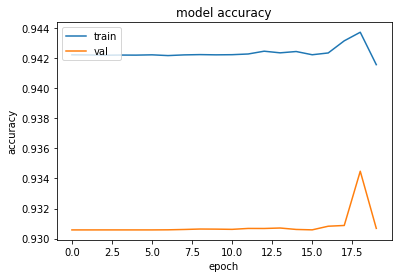

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Loss

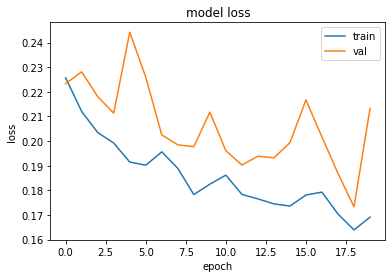

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Final model loss plot <br><br>
![Model Loss](https://github.com/max-gmann/MB_Mobility_DamageDetection/blob/main/ressources/screenshots/sample_prediction_0.png?raw=true)


Final model accuray plot <br><br>
![Model Accuracy](https://github.com/max-gmann/MB_Mobility_DamageDetection/blob/main/ressources/screenshots/accuracy.png?raw=true)

##### Plotting prediction results

In [59]:
val_gen = Dataset(batch_size, (256,256), input_img_paths_val, annotation_img_paths_val)

val_preds = model.predict(val_gen)

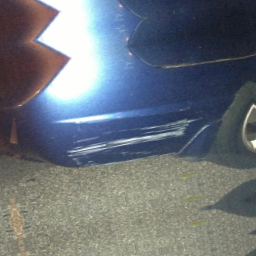

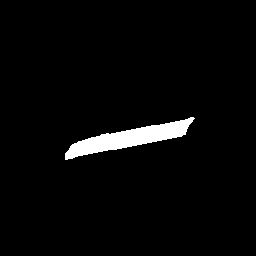

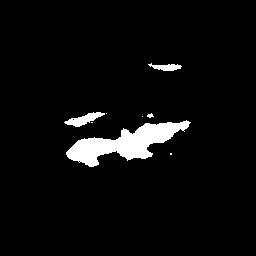

In [66]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

def display_mask(i):
    """utility to display a model's prediction."""

    thresh = 0.2
    fn = lambda x : 255 if x > thresh else 0
    vec = np.vectorize(fn)
    img = vec(val_preds[i])

    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(img))
    display(img)

# Index
i = 10

# Display input image
display(Image(filename=input_img_paths_val[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(annotation_img_paths_val[i]))
display(img)

display_mask(i)  

#### Test Images
Image 1<br>
![](https://github.com/max-gmann/MB_Mobility_DamageDetection/blob/main/ressources/screenshots/sample_prediction_0.png?raw=true)
<br>
Image 2<br>
![](https://github.com/max-gmann/MB_Mobility_DamageDetection/blob/main/ressources/screenshots/sample_prediction_1.png?raw=true)

## 4. Conclusion

Given to the nature of such a small training data set and time restraints of this project I'm satisfied with the model's performance.
It sometimes does suprisingly well in following complex shapes. For some types of damages, however, it seems to default to a square block in the center of the image. It also appears to have problems with multiple horizontal scratches. Possible reasons for this include:
- the model wasn't trained long enough, as the training loss and validation loss have not converged yet.
- the model is very large and there are too few training images. Big deep learning models require huge amounts of data to deliver accurate results. While data augmentation expanded the training data to around 300 images, this is most likely still not enough.
- choice of loss function. Since the training data is highly imbalanced a different loss function such as Dice coefficent could yield better results.
- unsuitable data augmentation. This aspect of data preparation can be utilized more by creating more variations with additional transformations. 

To further improve the model's performance, these would be my next steps:
- Get more data. 
- Implement Transfer Learning with a pre-trained model. 
- Experiment with different model architectures and loss functions.
- Experiment with different augmentation methods and image sizes.
- Modularize the training and data loading process so the pipeline can be automated.
